In [ ]:
!pip install torch torchvision timm

Veri Setini Yükleyin

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Gerekli Kütüphaneleri ve Modeli Yükleme

In [ ]:
import time
import torch
from torch import nn, optim
from torchvision import datasets, transforms
from timm import create_model
import matplotlib.pyplot as plt

# GPU kullanımı
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Veri ön işleme (transform)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

# Veri setlerini yükleme
train_dataset = datasets.ImageFolder('/content/drive/MyDrive/dataset/train', transform=transform)
val_dataset = datasets.ImageFolder('/content/drive/MyDrive/dataset/val', transform=transform)
test_dataset = datasets.ImageFolder('/content/drive/MyDrive/dataset/test', transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)

# Vision Transformer (ViT) modeli
model = create_model('vit_base_patch16_224', pretrained=True, num_classes=len(train_dataset.classes))
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)






/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Train Model

Epoch 1/5
	Batch 1 - Loss: 0.1250, Accuracy: 0.9844
	Batch 2 - Loss: 0.1166, Accuracy: 0.9844
	Batch 3 - Loss: 0.0269, Accuracy: 1.0000
	Batch 4 - Loss: 0.0442, Accuracy: 1.0000
	Batch 5 - Loss: 0.0469, Accuracy: 0.9844
	Batch 6 - Loss: 0.0107, Accuracy: 1.0000
	Batch 7 - Loss: 0.0319, Accuracy: 0.9844
	Batch 8 - Loss: 0.0370, Accuracy: 0.9844
	Batch 9 - Loss: 0.0775, Accuracy: 0.9688
	Batch 10 - Loss: 0.0243, Accuracy: 1.0000
	Batch 11 - Loss: 0.0486, Accuracy: 0.9844
	Batch 12 - Loss: 0.0379, Accuracy: 1.0000
	Batch 13 - Loss: 0.0088, Accuracy: 1.0000
	Batch 14 - Loss: 0.0262, Accuracy: 0.9844
	Batch 15 - Loss: 0.0193, Accuracy: 1.0000
	Batch 16 - Loss: 0.0345, Accuracy: 0.9844
	Batch 17 - Loss: 0.0409, Accuracy: 0.9844
	Batch 18 - Loss: 0.0463, Accuracy: 0.9844
	Batch 19 - Loss: 0.0260, Accuracy: 0.9844
	Batch 20 - Loss: 0.0059, Accuracy: 1.0000
	Batch 21 - Loss: 0.1092, Accuracy: 0.9531
	Batch 22 - Loss: 0.0025, Accuracy: 1.0000
	Batch 23 - Loss: 0.0221, Accuracy: 0.9844
	Batch 24 

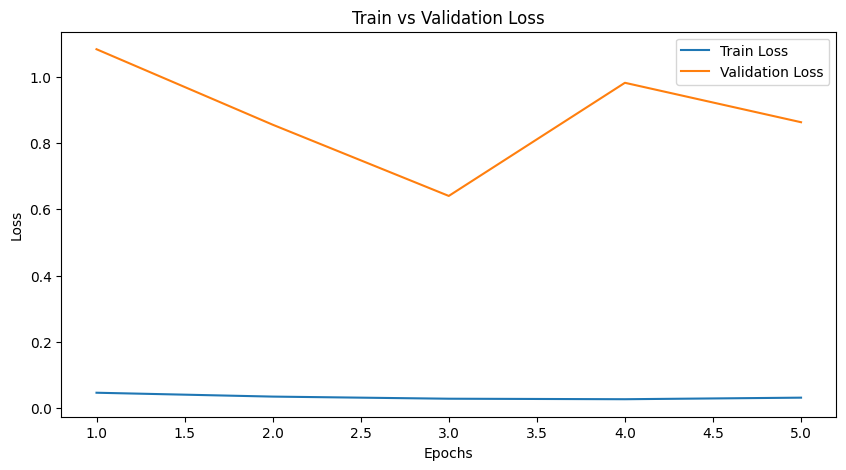

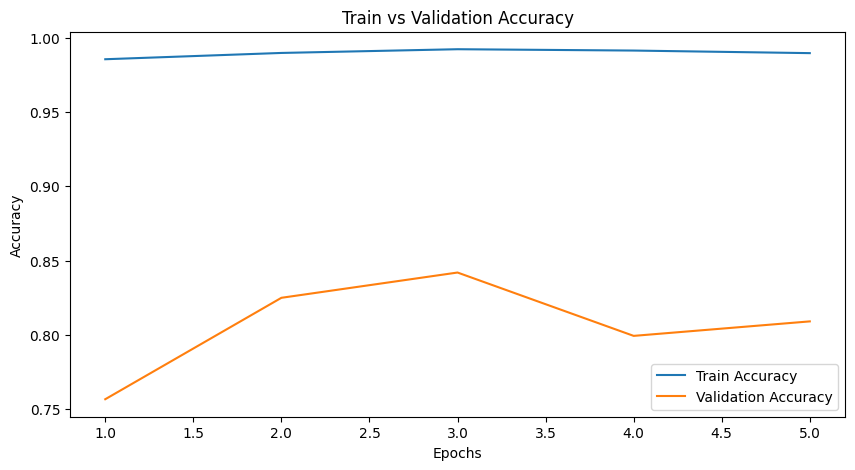

In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=5):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    # Eğitim zamanı ölçümü
    training_start_time = time.time()

    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")

        # Eğitim modu
        model.train()
        running_loss = 0.0
        running_corrects = 0
        total = 0

        for i, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            total += labels.size(0)

            # Batch sonrası Loss ve Accuracy'yi yazdır
            batch_loss = loss.item()
            batch_accuracy = torch.sum(preds == labels.data).double() / labels.size(0)
            print(f"\tBatch {i+1} - Loss: {batch_loss:.4f}, Accuracy: {batch_accuracy:.4f}")

        epoch_loss = running_loss / total
        epoch_acc = running_corrects.double() / total

        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc.item())
        print(f"Train - Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")

        # Validation
        model.eval()
        val_loss = 0.0
        val_corrects = 0
        val_total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                _, preds = torch.max(outputs, 1)
                val_loss += loss.item() * inputs.size(0)
                val_corrects += torch.sum(preds == labels.data)
                val_total += labels.size(0)

        val_epoch_loss = val_loss / val_total
        val_epoch_acc = val_corrects.double() / val_total

        val_losses.append(val_epoch_loss)
        val_accuracies.append(val_epoch_acc.item())
        print(f"Validation - Loss: {val_epoch_loss:.4f}, Accuracy: {val_epoch_acc:.4f}")

    training_end_time = time.time()
    training_time = training_end_time - training_start_time
    print(f"Total Training Time: {training_time:.2f} seconds")

    # Modeli kaydet
    torch.save(model.state_dict(), '/content/drive/MyDrive/vit_model.pth')
    print("Model saved to /content/drive/MyDrive/vit_model.pth")

    # Grafik çizimi
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
    plt.plot(range(1, epochs+1), val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Train vs Validation Loss')
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(range(1, epochs+1), train_accuracies, label='Train Accuracy')
    plt.plot(range(1, epochs+1), val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Train vs Validation Accuracy')
    plt.legend()
    plt.show()
train_model(model, train_loader, val_loader, criterion, optimizer, epochs=5)

Test Function

In [ ]:
def test_model(model, test_loader):
    model.eval()
    test_start_time = time.time()

    test_corrects = 0
    test_total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            _, preds = torch.max(outputs, 1)
            test_corrects += torch.sum(preds == labels.data)
            test_total += labels.size(0)

    test_accuracy = test_corrects.double() / test_total
    test_end_time = time.time()
    test_time = test_end_time - test_start_time

    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"Inference Time: {test_time:.2f} seconds")
test_model(model, test_loader)


Test Accuracy: 0.7683
Inference Time: 215.06 seconds
